# Аналитика поездок GoFast

Вы аналитик популярного сервиса аренды самокатов GoFast. Вам передали данные о некоторых пользователях из нескольких городов, а также об их поездках. Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:

- без подписки

абонентская плата отсутствует;

стоимость одной минуты поездки — 8 рублей;

стоимость старта (начала поездки) — 50 рублей;

- с подпиской Ultra

абонентская плата — 199 рублей в месяц;

стоимость одной минуты поездки — 6 рублей;

стоимость старта — бесплатно.

# Цель проекта

Проанализировать данные и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти.

# План исследования

- Загрузка данных
- Предобработка данных
- Исследовательский анализ данных
- Объединение данных
- Подсчёт выручки
- Проверка гипотез
- Распределения

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statistics import median
from scipy import stats as st

## Шаг 1. Загрузка данных

### Загружу и изучу датасеты

In [2]:
users = pd.read_csv('/datasets/users_go.csv')
users

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
...,...,...,...,...,...
1560,829,Федор,29,Пятигорск,free
1561,809,Юрий,26,Сочи,free
1562,307,Ясмина,19,Краснодар,ultra
1563,47,Юрий,28,Тюмень,ultra


In [3]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [4]:
rides = pd.read_csv('/datasets/rides_go.csv')
rides

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
...,...,...,...,...
18063,1534,3781.098080,19.822962,2021-11-04
18064,1534,2840.423057,21.409799,2021-11-16
18065,1534,3826.185507,18.435051,2021-11-18
18066,1534,2902.308661,16.674362,2021-11-27


In [5]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [6]:
subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')
subscriptions

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [7]:
subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


### Вывод

Первый датафрейм содержит информацию о пользователях. Имя, город и тип подписки - строки, персональный ID и возраст - целые числа. В датафрейме нет пропусков

Второй - информация о поездках. Также содержит ID, который связывает его с первым датафреймом. Длительность и дальность поездки - числа с плавающей точкой, дата в формате строки. Пропусков нет

Третий - всего две строки - информация о тарифах. Содержит тип подписки, связывающий его с первым датафреймом. Цены за минуту, старт и подписку - целые числа. Пропусков нет

## Шаг 2. Предобработка данных

### Приведу столбец date в формат datetime и запишу месяц в отдельный столбец

In [8]:
rides['date'] = pd.to_datetime(rides['date'])
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


Проверяю период

In [10]:
rides['date'].dt.year.unique()

array([2021])

Датафрейм содержит данные в пределах одного 2021 года

In [12]:
rides['month'] = rides['date'].dt.month
rides

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8
...,...,...,...,...,...
18063,1534,3781.098080,19.822962,2021-11-04,11
18064,1534,2840.423057,21.409799,2021-11-16,11
18065,1534,3826.185507,18.435051,2021-11-18,11
18066,1534,2902.308661,16.674362,2021-11-27,11


### Проверяю пропуски в данных

In [13]:
users.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [14]:
rides.isna().sum()

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

In [15]:
subscriptions.isna().sum()

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

В данных нет пропусков

### Проверяю дубликаты

In [16]:
users.duplicated().sum()

31

In [17]:
users = users.drop_duplicates()

In [18]:
rides.duplicated().sum()

0

In [19]:
subscriptions.duplicated().sum()

0

### Обработаю значения длительности

Дальность имеет формат до шести знаков после точки, округлю до двух

In [ ]:
rides['distance'] = rides['distance'].round(2)
rides

,user_id,distance,duration,date,month
0,1,4409.92,25.599769,2021-01-01,1
1,1,2617.59,15.816871,2021-01-18,1
2,1,754.16,6.232113,2021-04-20,4
3,1,2694.78,18.511000,2021-08-11,8
4,1,4028.69,26.265803,2021-08-28,8
...,...,...,...,...,...
18063,1534,3781.10,19.822962,2021-11-04,11
18064,1534,2840.42,21.409799,2021-11-16,11
18065,1534,3826.19,18.435051,2021-11-18,11
18066,1534,2902.31,16.674362,2021-11-27,11


### Рассмотрю аномалии расстояний и длительности

In [22]:
rides['distance'].describe()

count    18068.000000
mean      3070.659992
std       1116.831222
min          0.860000
25%       2543.227500
50%       3133.610000
75%       3776.220000
max       7211.010000
Name: distance, dtype: float64

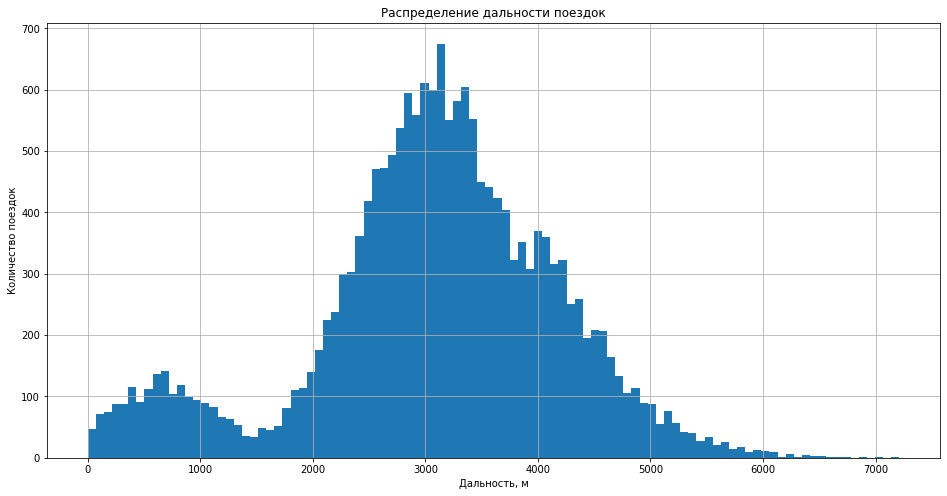

In [23]:
rides['distance'].hist(figsize=(16, 8), bins=100)
plt.ylabel('Количество поездок')
plt.xlabel('Дальность, м')
plt.title('Распределение дальности поездок');

In [24]:
rides['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

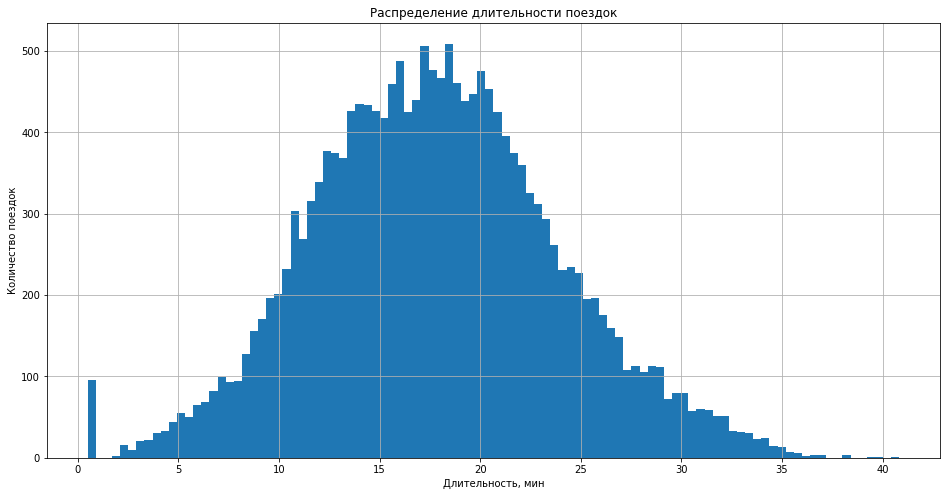

In [25]:
rides['duration'].hist(figsize=(16, 8), bins=100)
plt.ylabel('Количество поездок')
plt.xlabel('Длительность, мин')
plt.title('Распределение длительности поездок');

На графике длительности поездок видны аномально короткие поездки в пределах минуты. Это может быть связано с неисправностями самокатов, проверкой работы приложения или неисправности в алгоритме считывания длительности. Рассмотрю их внимательно

In [26]:
rides.query('duration < 1').head(10)

,user_id,distance,duration,date,month
6531,701,4196.45,0.5,2021-08-31,8
6570,704,4830.82,0.5,2021-10-14,10
6680,712,4684.00,0.5,2021-03-04,3
6695,713,5215.64,0.5,2021-02-25,2
6768,718,5197.44,0.5,2021-02-11,2
6860,724,6225.52,0.5,2021-12-16,12
6883,726,4452.49,0.5,2021-03-01,3
7018,735,4406.95,0.5,2021-04-13,4
7160,745,5286.17,0.5,2021-08-17,8
7364,760,4881.39,0.5,2021-08-29,8


Расстояние явно не соответствует длительности поездки, и длительность ровно полминуты. Стоит обратить внимание на ошибку считывания длительности поездки

Тем не менее длительность поездки влияет на формирование выручки, поэтому оставлю эти данные, тем более эти данные значимы для дальнейшего анализа расстояния

### Вывод

- Проверила даты - период в рамках одного года
- Пропусков в данных нет
- Есть дубликаты данных о пользователях, удалила их
- Округлила избыточные данные о расстоянии и длительности
- Нашла ошибки в записи длительности, на которые стоит обратить особое внимание

## Шаг 3. Исследовательский анализ данных

### Частота встречаемости городов

In [27]:
cities = users.groupby(by='city')['city'].count().sort_values(ascending=True)
cities

city
Москва            168
Тюмень            180
Омск              183
Сочи              189
Краснодар         193
Ростов-на-Дону    198
Екатеринбург      204
Пятигорск         219
Name: city, dtype: int64

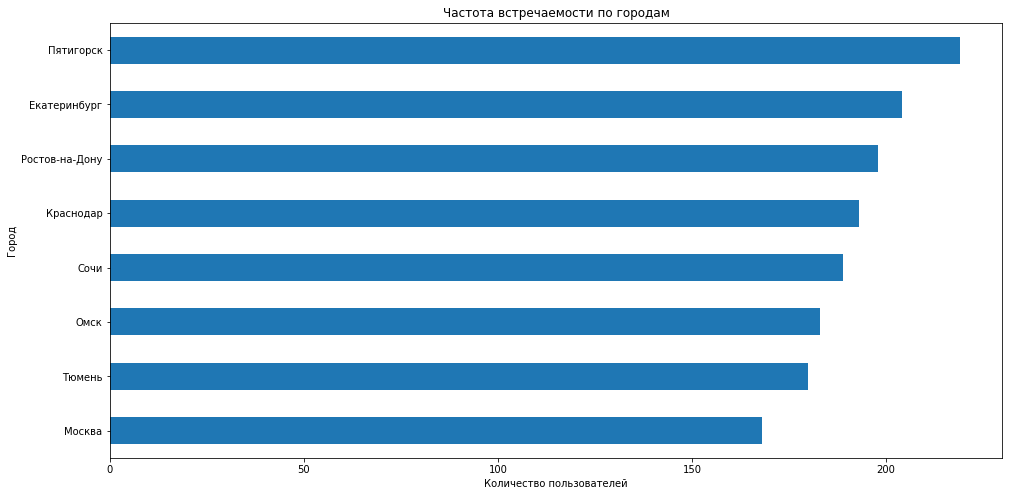

In [28]:
cities.plot(x='count', y='city', kind='barh', figsize=(16, 8))
plt.title('Частота встречаемости по городам')
plt.ylabel('Город')
plt.xlabel('Количество пользователей');

Во всех городах у сервиса сопоставимое количество пользователей, несмотря на значительные различия в населенности этих городов

### Соотношение пользователей с подпиской и без подписки

In [29]:
subs= users.groupby(by='subscription_type')['subscription_type'].count()
subs

subscription_type
free     835
ultra    699
Name: subscription_type, dtype: int64

In [30]:
subs_ratio = subs/subs.sum()*100
subs_ratio

subscription_type
free     54.432855
ultra    45.567145
Name: subscription_type, dtype: float64

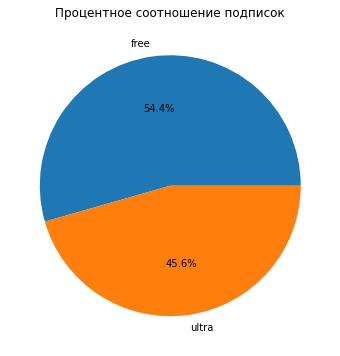

In [31]:
plt.figure(figsize=(6, 6))
subs_ratio.plot(kind='pie', autopct='%1.1f%%', ylabel='')
plt.title('Процентное соотношение подписок');


Чуть меньше половины пользователей оплачивают подписку

### Возраст пользователей

In [32]:
users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

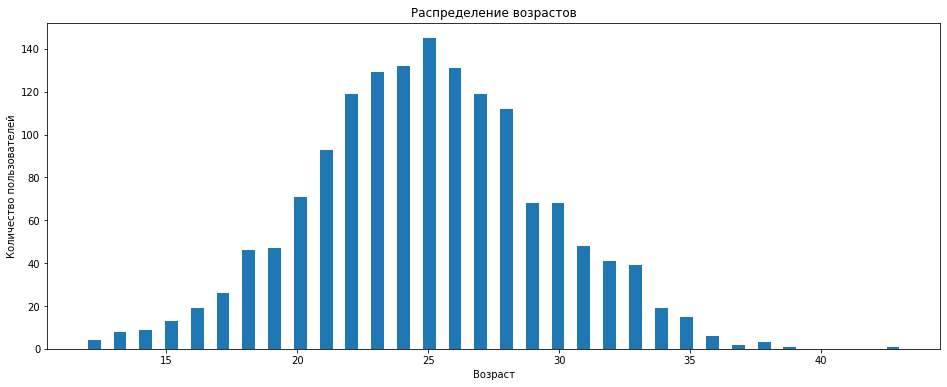

In [33]:
plt.figure(figsize=(16, 6))
users['age'].plot(kind='hist', bins=63)
plt.ylabel('Количество пользователей')
plt.xlabel('Возраст')
plt.title('Распределение возрастов');

Нормальное симметричное распределение с пиком на 26 годах. Средний возраст пользователя - 25 лет

Возраст пользователей - от 12 до 43 лет, хотя прокат самокатов разрешен с 18 лет (иногда - с 14 при письменном согласии родителей). Стоит обращать особое внимание на возраст при регистрации пользователя, чтобы не нарушать нормы

### Расстояние, которое пользователь преодолел за одну поездку

In [34]:
rides['distance'].describe()

count    18068.000000
mean      3070.659992
std       1116.831222
min          0.860000
25%       2543.227500
50%       3133.610000
75%       3776.220000
max       7211.010000
Name: distance, dtype: float64

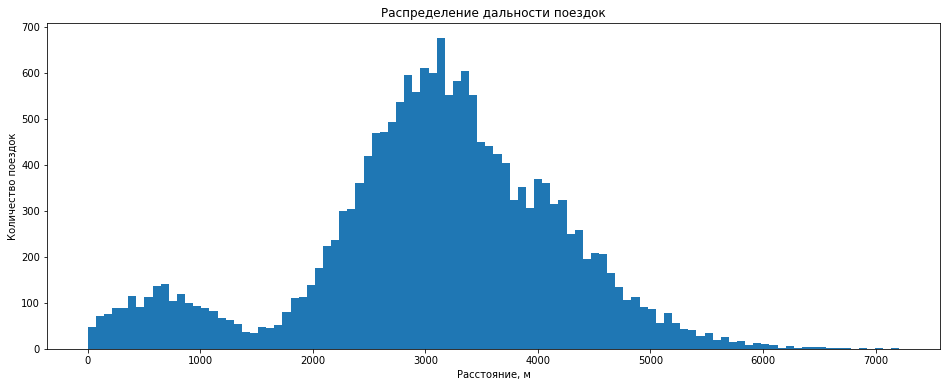

In [35]:
plt.figure(figsize=(16, 6))
rides['distance'].plot(kind='hist', bins=100)
plt.ylabel('Количество поездок')
plt.xlabel('Расстояние, м')
plt.title('Распределение дальности поездок');

В основном пользователи совершают поездки от 2 до 5 км, пик приходится примерно на 3 км. Но есть также небольшая часть пользователей, которые совершают очень короткие поездки, с пиком примерно на 600 м. В среднем дальность поездки составляет 3 км

### Продолжительность поездок

In [36]:
rides['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

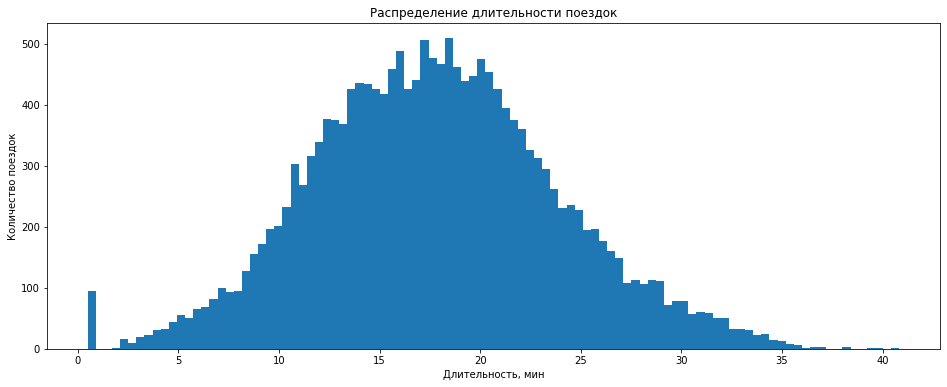

In [37]:
plt.figure(figsize=(16, 6))
rides['duration'].plot(kind='hist', bins=100)
plt.ylabel('Количество поездок')
plt.xlabel('Длительность, мин')
plt.title('Распределение длительности поездок');

Нормальное симметричное распределение с расплывчатым пиком на 15-20 минутах. Средняя длительность - 18 минут. Есть выброс на 0,5 минуты - как указано выше, это ошибка контроля времени поездки

### Вывод

- Во всех городах у сервиса сопоставимое количество пользователей, несмотря на значительные различия в населенности этих городов
- Чуть меньше половины пользователей оплачивают подписку
- Возраст пользователей - от 12 до 43 лет. Пиковый возраст - 26 лет. Средний - 25 лет

**Стоит обращать особое внимание на возраст при регистрации пользователя, чтобы не нарушать нормы, так как прокат самокатов разрешен с 18 лет (иногда - с 14 при письменном согласии родителей)**

- Пик дальности поездки, а так же среднее расстояние приходятся примерно на 3 км. Но есть также небольшая часть пользователей, которые совершают очень короткие поездки, с пиком примерно на 600 м. 
- Пик длительности поездки приходится на 15-20 минут. Средняя длительность - 18 минут. 

**Есть поездки с длительностью 0,5 минуты и несоответствующим этой длительности расстоянием. Стоит обратить внимание на эту ошибку контроля времени поездки**

## Шаг 4. Объединение данных

### Объединю данные о пользователях, поездках и подписках в один датафрейм. 

In [38]:
data = users.merge(rides, on='user_id', how='left').merge(subscriptions, on='subscription_type', how='left')
data

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.92,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.59,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.16,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.78,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.69,26.265803,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.10,19.822962,2021-11-04,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.42,21.409799,2021-11-16,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.19,18.435051,2021-11-18,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.31,16.674362,2021-11-27,11,8,50,0


In [39]:
data.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
distance             0
duration             0
date                 0
month                0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

### Разделю данные о пользователях с платной и бесплатной подпиской на разные датафреймы

In [40]:
free = data[data['subscription_type'] == 'free']
free

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.69,14.944286,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.93,16.234663,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.43,20.016628,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.91,9.782872,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.38,17.427673,2021-02-14,2,8,50,0
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.10,19.822962,2021-11-04,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.42,21.409799,2021-11-16,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.19,18.435051,2021-11-18,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.31,16.674362,2021-11-27,11,8,50,0


In [41]:
ultra = data[data['subscription_type'] == 'ultra']
ultra

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.92,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.59,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.16,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.78,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.69,26.265803,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
6495,699,Оксана,22,Москва,ultra,3973.05,24.671163,2021-08-29,8,6,0,199
6496,699,Оксана,22,Москва,ultra,3288.70,15.892886,2021-09-12,9,6,0,199
6497,699,Оксана,22,Москва,ultra,3076.16,14.389525,2021-09-26,9,6,0,199
6498,699,Оксана,22,Москва,ultra,4707.85,15.839579,2021-10-17,10,6,0,199


### Рассмотрю длительность поездок

In [42]:
free['duration'].describe()

count    11568.000000
mean        17.390909
std          6.326803
min          0.500000
25%         12.958437
50%         17.326890
75%         21.594071
max         34.948498
Name: duration, dtype: float64

In [43]:
ultra['duration'].describe()

count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64

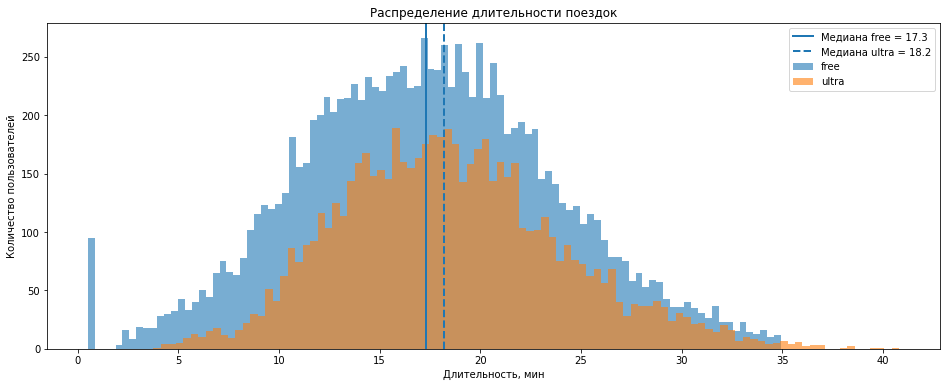

In [44]:
med_duration_free = median(free['duration'])
med_duration_ultra = median(ultra['duration'])

plt.figure(figsize=(16, 6))

plt.hist(free['duration'], bins=100, alpha=0.6, label='free')
plt.hist(ultra['duration'], bins=100, alpha=0.6, label='ultra')

plt.axvline(med_duration_free, linewidth=2, label=f'Медиана free = {med_duration_free:.1f}')
plt.axvline(med_duration_ultra, linestyle='--', linewidth=2, label=f'Медиана ultra = {med_duration_ultra:.1f}')

plt.ylabel('Количество пользователей')
plt.xlabel('Длительность, мин')
plt.title('Распределение длительности поездок')
plt.legend();

### Рассмотрю расстояние

In [45]:
free['distance'].describe()

count    11568.000000
mean      3045.495284
std       1246.173810
min          0.860000
25%       2366.560000
50%       3114.650000
75%       3905.695000
max       7211.010000
Name: distance, dtype: float64

In [46]:
ultra['distance'].describe()

count    6500.000000
mean     3115.445431
std       836.895369
min       244.210000
25%      2785.447500
50%      3148.640000
75%      3560.577500
max      5699.770000
Name: distance, dtype: float64

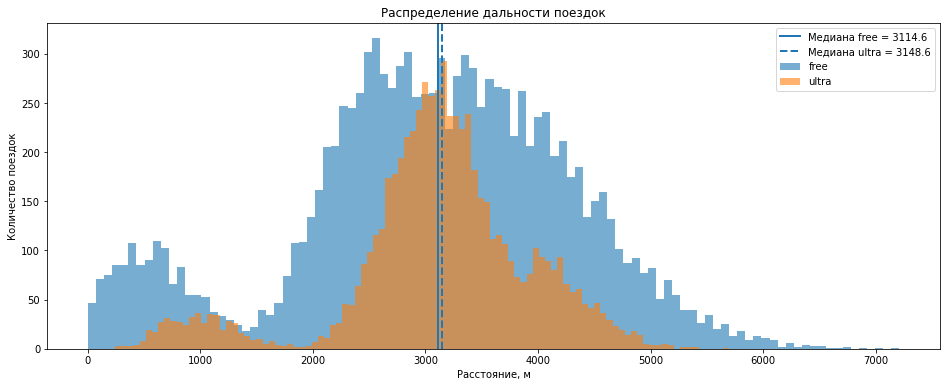

In [47]:
med_distance_free = median(free['distance'])
med_distance_ultra = median(ultra['distance'])

plt.figure(figsize=(16, 6))

plt.hist(free['distance'], bins=100, alpha=0.6, label='free')
plt.hist(ultra['distance'], bins=100, alpha=0.6, label='ultra')

plt.axvline(med_distance_free, linewidth=2, label=f'Медиана free = {med_distance_free:.1f}')
plt.axvline(med_distance_ultra, linestyle='--', linewidth=2, label=f'Медиана ultra = {med_distance_ultra:.1f}')

plt.ylabel('Количество поездок')
plt.xlabel('Расстояние, м')
plt.title('Распределение дальности поездок')
plt.legend();

### Вывод

- Пользователи с подпиской ultra в среднем совершают более длительные поездки. При этом, быстрых поездок меньше по сравнению с пользователями free

- Пользователи с подпиской free чаще совершают очень короткие либо очень длинные поездки, в то время как дальность поездок пользователей ultra более стабильна

- Распределения по обоим показателям значительно перекрываются, особенно в диапазоне средних значений, что говорит о схожем поведении пользователей вне зависимости от подписки. Тем не менее, различия в форме распределений и центральных тенденциях позволяют сделать вывод, что тип подписки влияет на характер использования сервиса

**Также здесь видно, что поездки с ошибочной длительностью присущи именно для бесплатной подписки**


## Шаг 5. Подсчёт выручки

### Агрегирую данные

Найду суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц

Так как оплата поминутная, округлю длительность каждой поездки до целого числа вверх

In [48]:
data['duration'] = np.ceil(data['duration'])
data

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.92,26.0,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.59,16.0,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.16,7.0,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.78,19.0,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.69,27.0,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.10,20.0,2021-11-04,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.42,22.0,2021-11-16,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.19,19.0,2021-11-18,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.31,17.0,2021-11-27,11,8,50,0


Агрегирую данные

In [49]:
agg_data = data.groupby(['user_id', 'month']).agg(
                                                  distance=('distance', 'sum'),
                                                  count=('distance', 'count'),
                                                  duration=('duration', 'sum')
                                                  ).reset_index()
agg_data

,user_id,month,distance,count,duration
0,1,1,7027.51,2,42.0
1,1,4,754.16,1,7.0
2,1,8,6723.47,2,46.0
3,1,10,5809.91,2,32.0
4,1,11,7003.50,3,56.0
...,...,...,...,...,...
11326,1534,6,3409.47,2,26.0
11327,1534,8,7622.45,2,48.0
11328,1534,9,4928.17,1,23.0
11329,1534,11,13350.02,4,78.0


In [50]:
agg_data.isna().sum()

user_id     0
month       0
distance    0
count       0
duration    0
dtype: int64

Проверяю пропуски в новой таблице, их нет

### Посчитаю помесячную выручку, которую принёс каждый пользователь

Для этого добавлю в датафрейм информацию о подписке и тарифах

In [51]:
user_subscription = users[['user_id', 'subscription_type']]
user_subscription['user_id'].is_unique

True

In [52]:
agg_data = agg_data.merge(user_subscription[['user_id', 'subscription_type']],
                          on='user_id',
                          how='left',
                          validate='many_to_one'
                          )
agg_data

,user_id,month,distance,count,duration,subscription_type
0,1,1,7027.51,2,42.0,ultra
1,1,4,754.16,1,7.0,ultra
2,1,8,6723.47,2,46.0,ultra
3,1,10,5809.91,2,32.0,ultra
4,1,11,7003.50,3,56.0,ultra
...,...,...,...,...,...,...
11326,1534,6,3409.47,2,26.0,free
11327,1534,8,7622.45,2,48.0,free
11328,1534,9,4928.17,1,23.0,free
11329,1534,11,13350.02,4,78.0,free


In [53]:
agg_data = agg_data.merge(subscriptions,
                          on='subscription_type',
                          how='left')
agg_data

,user_id,month,distance,count,duration,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,1,7027.51,2,42.0,ultra,6,0,199
1,1,4,754.16,1,7.0,ultra,6,0,199
2,1,8,6723.47,2,46.0,ultra,6,0,199
3,1,10,5809.91,2,32.0,ultra,6,0,199
4,1,11,7003.50,3,56.0,ultra,6,0,199
...,...,...,...,...,...,...,...,...,...
11326,1534,6,3409.47,2,26.0,free,8,50,0
11327,1534,8,7622.45,2,48.0,free,8,50,0
11328,1534,9,4928.17,1,23.0,free,8,50,0
11329,1534,11,13350.02,4,78.0,free,8,50,0


In [54]:
agg_data.isna().sum()

user_id              0
month                0
distance             0
count                0
duration             0
subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

Таблицы объединились корректно, пропусков нет

Рассчитаю выручку

In [55]:
agg_data['income'] = (agg_data['count'] * agg_data['start_ride_price']
                     + agg_data['duration'] * agg_data['minute_price']
                     + agg_data['subscription_fee']
                     )
agg_data

,user_id,month,distance,count,duration,subscription_type,minute_price,start_ride_price,subscription_fee,income
0,1,1,7027.51,2,42.0,ultra,6,0,199,451.0
1,1,4,754.16,1,7.0,ultra,6,0,199,241.0
2,1,8,6723.47,2,46.0,ultra,6,0,199,475.0
3,1,10,5809.91,2,32.0,ultra,6,0,199,391.0
4,1,11,7003.50,3,56.0,ultra,6,0,199,535.0
...,...,...,...,...,...,...,...,...,...,...
11326,1534,6,3409.47,2,26.0,free,8,50,0,308.0
11327,1534,8,7622.45,2,48.0,free,8,50,0,484.0
11328,1534,9,4928.17,1,23.0,free,8,50,0,234.0
11329,1534,11,13350.02,4,78.0,free,8,50,0,824.0


Теперь можно удалить вспомогательные столбцы

In [56]:
agg_data = agg_data.drop(['minute_price', 'start_ride_price', 'subscription_fee'], axis=1)
agg_data

,user_id,month,distance,count,duration,subscription_type,income
0,1,1,7027.51,2,42.0,ultra,451.0
1,1,4,754.16,1,7.0,ultra,241.0
2,1,8,6723.47,2,46.0,ultra,475.0
3,1,10,5809.91,2,32.0,ultra,391.0
4,1,11,7003.50,3,56.0,ultra,535.0
...,...,...,...,...,...,...,...
11326,1534,6,3409.47,2,26.0,free,308.0
11327,1534,8,7622.45,2,48.0,free,484.0
11328,1534,9,4928.17,1,23.0,free,234.0
11329,1534,11,13350.02,4,78.0,free,824.0


### Изучу данные о помесячной выручке

In [63]:
agg_data['income'].describe()

count    11331.000000
mean       342.303504
std        153.875346
min         58.000000
25%        234.000000
50%        319.000000
75%        415.000000
max       1444.000000
Name: income, dtype: float64

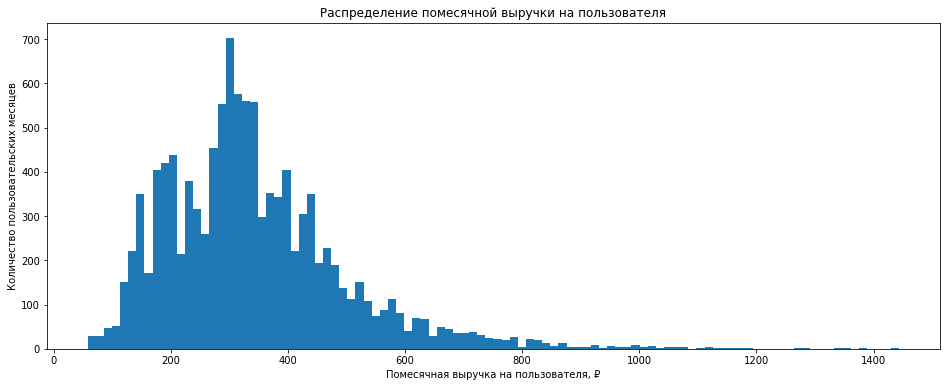

In [64]:
plt.figure(figsize=(16, 6))
agg_data['income'].plot(kind='hist', bins=100)
plt.ylabel('Количество пользовательских месяцев')
plt.xlabel('Помесячная выручка на пользователя, ₽')
plt.title('Распределение помесячной выручки на пользователя');

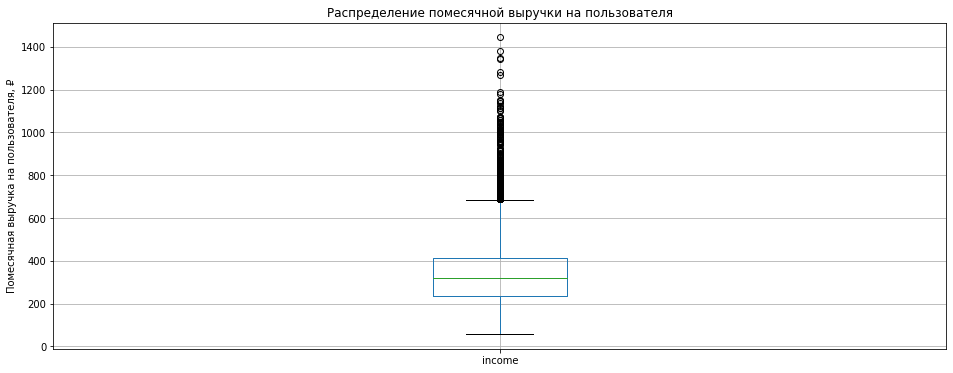

In [65]:
plt.figure(figsize=(16, 6))
agg_data.boxplot(column='income')
plt.ylabel('Помесячная выручка на пользователя, ₽')
plt.title('Распределение помесячной выручки на пользователя');

### Вывод

Распределение помесячной выручки на пользователя скошено вправо: в среднем пользователь приносит в месяц 342₽, что превышает медиану 319₽, и наблюдается правый хвост распределения. При этом стандартное отклонение 154 ₽ сопоставимо с половиной среднего значения, что указывает на существенную вариативность дохода

## Шаг 6. Проверка гипотез

### Гипотеза 1

Тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании

Исследую совокупности длительностей поездок пользователей без подписки и с подпиской и сравниваю их средние

In [66]:
# с подпиской
sample1 = data[data['subscription_type'] == 'ultra']['duration']
print('Размер выборки:', sample1.shape[0])
print('Среднее выборки:', sample1.mean())

Размер выборки: 6500
Среднее выборки: 19.037692307692307


In [67]:
# без подписки
sample2 = data[data['subscription_type'] == 'free']['duration']
print('Размер выборки:', sample2.shape[0])
print('Среднее выборки:', sample2.mean())

Размер выборки: 11568
Среднее выборки: 17.890992392807746


Использую односторонний двухвыборочный t-тест для независимых выборок

H₀ (нулевая гипотеза):
- Среднее время поездок пользователей с подпиской не больше среднего времени поездок пользователей без подписки
- μ1 ≤ μ2

H₁ (альтернативная гипотеза):
- Среднее время поездок пользователей с подпиской больше среднего времени поездок пользователей без подписки
- μ1 > μ2

Выбираю уровень статистической значимости alpha=0.05

Так как размеры выборок различаются, указываю, что дисперсии выборок не равны

In [68]:
alpha = 0.05

results = st.ttest_ind(sample1, sample2, equal_var=False, alternative='greater')


print('Значение pvalue равно', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Значение pvalue равно 1.1814679253701353e-36
Отвергаем нулевую гипотезу


Вероятность получить такое же или более экстремальное различие средних, если нулевая гипотеза H₀ верна, меньше выбранного уровня статистической значимости, поэтому отвергаю гипотезу о том, что среднее время поездок пользователей с подпиской не больше среднего времени поездок пользователей без подписки

### Гипотеза 2

Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?

Исследую совокупность дальностей поездок пользователей с подпиской и сравниваю ее среднее с числом 3130

In [69]:
sample3 = data[data['subscription_type'] == 'ultra']['distance']
sample3.mean()

3115.445430769231

Использую односторонний одновыборочный t-тест

H₀ (нулевая гипотеза):
- Среднее расстояние за одну поездку не больше оптимального значения в 3130 метров
- μ ≤ 3130

H₁ (альтернативная гипотеза):
- Среднее расстояние за одну поездку больше, чем 3130 метров
- μ > 3130

Выбираю уровень статистической значимости alpha=0.05

In [70]:
alpha = 0.05
value = 3130

results = st.ttest_1samp(sample3, value, alternative='greater')


print('Значение pvalue равно', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Значение pvalue равно 0.9195362605842414
Не получилось отвергнуть нулевую гипотезу


Вероятность получить такое же или более экстремальное различие средних, если нулевая гипотеза H₀ верна, выше выбранного уровня статистической значимости, поэтому не получилось отвернуть гипотезу о том, что среднее расстояние за одну поездку не больше оптимального значения расстояния одной поездки с точки зрения износа самоката

### Гипотеза 3

Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?

Исследую совокупности помесячных выручек от пользователей без подписки и с подпиской и сравниваю их средние

In [71]:
# с подпиской
sample4 = agg_data[agg_data['subscription_type'] == 'ultra']['income']
print('Размер выборки:', sample4.shape[0])
print('Среднее выборки:', sample4.mean())

Размер выборки: 4533
Среднее выборки: 362.7921906022502


In [72]:
# без подписки
sample5 = agg_data[agg_data['subscription_type'] == 'free']['income']
print('Размер выборки:', sample5.shape[0])
print('Среднее выборки:', sample5.mean())

Размер выборки: 6798
Среднее выборки: 328.6413651073845


Использую односторонний двухвыборочный t-тест для независимых выборок

H₀ (нулевая гипотеза):
- Средняя помесячная выручка от пользователей с подпиской не выше, чем средняя помесячная выручка от пользователей без подписки
- μ1 ≤ μ2

H₁ (альтернативная гипотеза):
- Средняя помесячная выручка от пользователей с подпиской выше, чем средняя помесячная выручка от пользователей без подписки
- μ1 > μ2

Выбираю уровень статистической значимости alpha=0.05

Так как размеры выборок различаются, указываю, что дисперсии выборок не равны

In [73]:
alpha = 0.05

results = st.ttest_ind(sample4, sample5, equal_var=False, alternative='greater')


print('Значение pvalue равно', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Значение pvalue равно 8.874140893976874e-40
Отвергаем нулевую гипотезу


Вероятность получить такое же или более экстремальное различие средних, если нулевая гипотеза H₀ верна, меньше выбранного уровня статистической значимости, поэтому отвергаю гипотезу о том, что средняя помесячная выручка от пользователей с подпиской не выше, чем средняя помесячная выручка от пользователей без подписки

### Гипотеза 4

Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

Первая выборка:
- Данные для каждого пользователя о количестве обращений после обновления
- μ_after

Вторая выборка:
- Данные для каждого пользователя о количестве обращений до обновления
- μ_before

H₀ (нулевая гипотеза):
- Среднее количество обращений после обновления не меньше, чем до обновления.
- μ_after ≥ μ_before

H₁ (альтернативная гипотеза):
- Среднее количество обращений после обновления меньше, чем до обновления.
- μ_after < μ_before

Для проверки этой гипотезы понадобится односторонний двухвыборочный t-тест для зависимых выборок, метод ttest_rel, параметр aternative='less'

### Вывод

- В первой задаче отвергла гипотезу о том, что среднее время поездок пользователей с подпиской не больше среднего времени поездок пользователей без подписки

- Во второй задаче не получилось отвернуть гипотезу о том, что среднее расстояние за одну поездку не больше оптимального значения расстояния одной поездки с точки зрения износа самоката

- В третьей задаче отвергла гипотезу о том, что средняя помесячная выручка от пользователей с подпиской не выше, чем средняя помесячная выручка от пользователей без подписки

- Описала метод, гипотезы и параметры для четвертой задачи

## Шаг 7. Распределения

### Задача 1. Акция с раздачей промокодов

Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж.

Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

- Здесь возможны два исхода испытания: после бесплатного месяца подписки пользователь либо продлевает подписку, либо нет.
- Испытания независимо повторяются фиксированное количество раз, по количеству высланных промокодов

Такую ситуацию описывают биноминальным распределением

#### Найду минимальное необходимое количество промокодов

Подберу минимальное значение n, при котором вероятность не выполнить план (получить менее 100 продлений) становится меньше 5 %

In [74]:
p = 0.1 
alpha = 0.05    
for n in range(1000, 1500):
    prob = st.binom.cdf(99, n, p)  # P(X < 100)
    if prob < alpha:
        print(f'Минимальное число промокодов: {n}')
        break

Минимальное число промокодов: 1161


#### Построю график распределения

/opt/conda/lib/python3.9/site-packages/scipy/stats/_discrete_distns.py:78: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


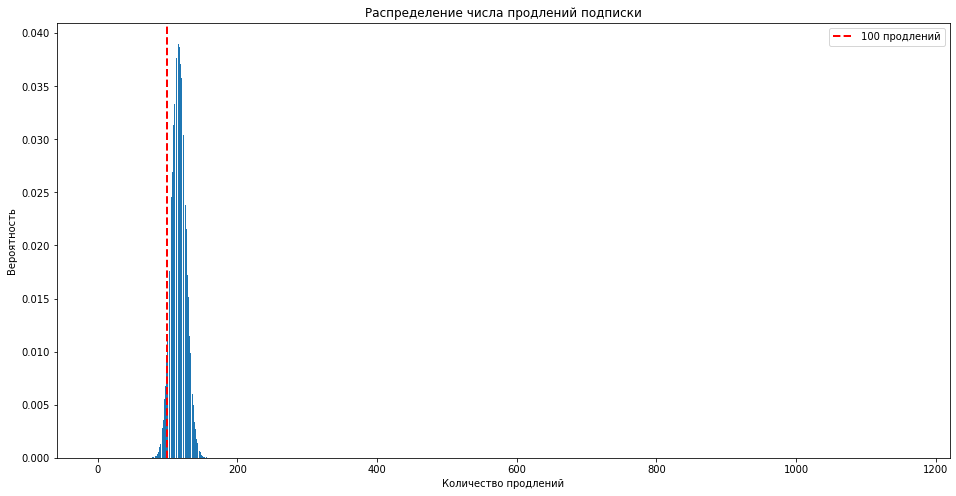

In [75]:
distr = []

for k in range(0, n + 1):
    current_value = st.binom.pmf(k, n, p)
    distr.append(current_value)

plt.figure(figsize=(16, 8))
plt.bar(range(0, n + 1), distr)
plt.axvline(100, linestyle='--', linewidth=2, color='red', label='100 продлений')
plt.xlabel('Количество продлений')
plt.ylabel('Вероятность')
plt.title('Распределение числа продлений подписки')
plt.legend()
plt.show();

#### Вывод

В результате расчета выяснила, что нужно выслать не менее 1611 промокодов, чтобы вероятность не получить 100 продлений подписки была не больше 5%

### Задача 2. Push-уведомления в мобильном приложении

Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений.

С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

#### Рассмотрю параметры распределения

In [76]:
# количество испытаний
n = 1000000

# вероятность успеха
p = 0.4

Параметр n достаточно велик, а параметр p близок к 0,5, поэтому рассмотрю нормальную аппроксимацию

In [77]:
# математическое ожидание
mu = n * p

# стандартное отклонение
sigma = (n * p * (1 - p))**0.5

Найду промежуток от математического ожидания биномиального распределения плюс-минус три его стандартных отклонения

In [78]:
x1 = mu-3*sigma
x2 = mu+3*sigma

print(f'[{x1},{x2}]')

[398530.3061543301,401469.6938456699]


Этот промежуток лежит в пределах [0,1 000 000] (то есть там, где биномиальное распределение определено), значит его форма будет симметрична и близка к нормальному распределению, поэтому нормальное распределение даст хорошую аппроксимацию

#### Оценю вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

In [79]:
distr = st.norm(mu, sigma) 

result = distr.cdf(399500)
print('Вероятность равна', result)

Вероятность равна 0.15371708296369768


#### Построю график распределения

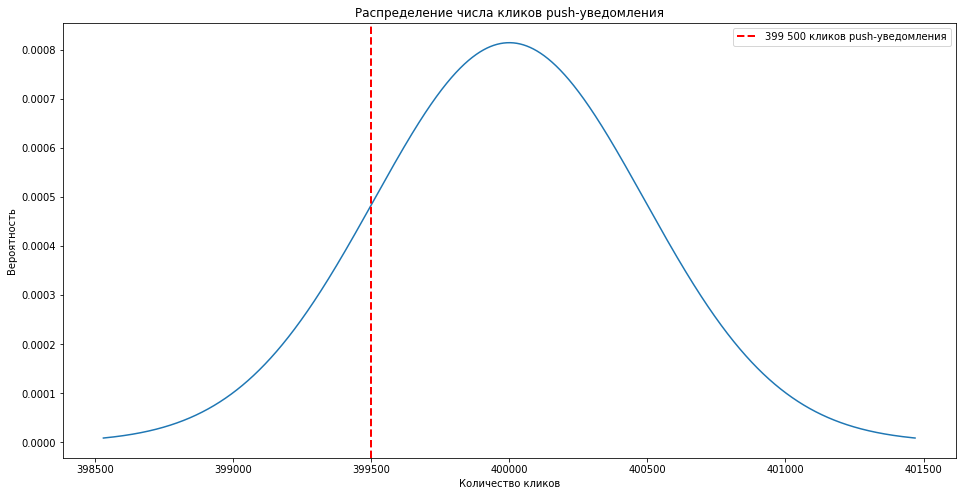

In [80]:
arange = np.arange(x1, x2)
plt.figure(figsize=(16, 8))
plt.plot(arange, st.norm.pdf(arange, mu, sigma))
plt.axvline(399500, linestyle='--', linewidth=2, color='red', label='399 500 кликов push-уведомления')
plt.xlabel('Количество кликов')
plt.ylabel('Вероятность')
plt.title('Распределение числа кликов push-уведомления')
plt.legend()
plt.show()

#### Вывод

- Определила, что нормальное распределение подходит для того, чтобы аппроксимировать им данное биноминальное распределение
- Рассчитала, что вероятность того, что уведомление откроют не более 399,5 тыс. пользователей приблизительно равна 15,4%

## Общий вывод

- В ходе анализа были изучены данные сервиса аренды самокатов, включающие информацию о пользователях, поездках и тарифах. Исходные данные представлены тремя датафреймами и в целом имеют корректную структуру. Были обнаружены ошибки в записи длительности некоторых поездок, на которые следует обратить внимание при дальнейшем использовании данных.


- Анализ пользовательской базы показал, что во всех городах сервиса количество пользователей сопоставимо, несмотря на различия в численности населения. Около половины пользователей оформляют подписку Ultra. Возраст пользователей варьируется от 12 до 43 лет, при среднем значении около 25 лет и пике в районе 26 лет. Наличие пользователей младше 18 лет указывает на необходимость усиленного контроля возрастных ограничений при регистрации, чтобы не нарушать правила использования сервиса.


- Поведенческий анализ поездок показал, что типичная дальность поездки составляет около 3 км, а длительность — 15–20 минут. При этом существует небольшая доля очень коротких поездок (около 600 м), а также зафиксированы аномальные поездки с крайне малой длительностью и несоответствующим расстоянием, что может указывать на ошибки контроля времени. Сравнение пользователей с разными типами подписки выявило, что пользователи с подпиской Ultra в среднем совершают более длительные и более стабильные поездки, тогда как пользователи без подписки чаще демонстрируют как очень короткие, так и очень длинные поездки. Несмотря на значительное перекрытие распределений, различия в форме и центральных тенденциях позволяют сделать вывод о влиянии типа подписки на характер использования сервиса. Также было отмечено, что поездки с ошибочной длительностью встречаются именно у пользователей без подписки.


- Анализ помесячной выручки на пользователя показал, что распределение дохода имеет правостороннюю асимметрию. Средняя выручка составляет около 342 ₽, что выше медианного значения (319 ₽), а наличие правого хвоста указывает на пользователей с высокой месячной активностью. Существенное стандартное отклонение (154 ₽) свидетельствует о высокой вариативности дохода между пользователями.


- В рамках проверки статистических гипотез было установлено, что пользователи с подпиской в среднем тратят на поездки больше времени, чем пользователи без подписки. При этом не удалось отвергнуть гипотезу о том, что среднее расстояние одной поездки не превышает оптимального значения с точки зрения износа самокатов. Также было подтверждено, что средняя помесячная выручка от пользователей с подпиской статистически значимо выше, чем от пользователей без подписки. Для дополнительной задачи были корректно сформулированы гипотезы и метод проверки.


- В прикладных задачах маркетинга было рассчитано, что для проведения акции с бесплатным месяцем подписки необходимо разослать не менее 1611 промокодов, чтобы вероятность не получить 100 продлений подписки не превышала 5 %. Кроме того, показано, что биномиальное распределение числа открытий push-уведомлений может быть аппроксимировано нормальным распределением, и вероятность того, что уведомление откроют не более 399,5 тыс. пользователей из 1 млн, составляет примерно 15,4 %.


В совокупности результаты анализа показывают, что подписка Ultra связана с более стабильным и интенсивным использованием сервиса и большей выручкой, а также подчёркивают важность контроля качества данных и возрастных ограничений пользователей для дальнейшего развития сервиса.